# Outliers

## Import Libraries

In [1]:
%matplotlib inline
import pylab
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
import os

pylab.rcParams.update({'font.size': 14})

### Data  
#### State google searches combined with personality variables.  Which states are outliers based on a single or combination of variables?

## Read CSV

In [2]:
dirpath = os.getcwd()
df = pd.read_csv(dirpath+"\\AnomalyData.csv")
df.head()

,State,state_code,data science,cluster analysis,college,startup,entrepreneur,ceo,mortgage,nba,...,obfuscation,unicorn,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness,PsychRegions,region,division
0,Alabama,AL,-1.00,-0.13,1.10,-0.68,0.15,-0.73,1.53,-0.74,...,-0.32,-1.03,55.5,52.7,55.5,48.7,42.7,1,3,6
1,Arizona,AZ,-0.42,-0.73,-0.10,0.11,0.57,0.25,0.95,0.38,...,0.38,0.10,50.6,46.6,58.4,38.1,54.7,2,4,8
2,Arkansas,AR,-0.66,-0.39,-0.64,-0.08,0.01,-0.66,-0.50,-0.71,...,-0.45,-0.32,49.9,52.7,41.0,56.2,40.3,1,3,7
3,California,CA,1.95,-0.62,-0.26,2.02,0.46,1.27,-0.97,1.46,...,0.70,-0.38,51.4,49.0,43.2,39.1,65.0,2,4,9
4,Colorado,CO,0.34,0.00,-0.61,1.49,0.05,0.33,1.38,-0.80,...,1.32,0.20,45.3,47.5,58.8,34.3,57.9,1,4,8


Save state_code to label outliers. "data" contains just quantitative variables.

In [3]:
state_code = df["state_code"]
data = df.loc[:, "data science": "Openness"]

## Univariate Outliers 
Create a box plot to display univariate outliers on "modern dance."

In [23]:
param = "modern dance"

Get quantile values and IQR for outlier limits.

In [24]:
qv1 = data[param].quantile(0.25)
qv2 = data[param].quantile(0.5)
qv3 = data[param].quantile(0.75)
qv_limit = 1.5 * (qv3 - qv1)

Get positions of outliers and use state_code for labels.

In [25]:
un_outliers_mask = (data[param] > qv3 + qv_limit) | (data[param] < qv1 - qv_limit)
un_outliers_data = data[param][un_outliers_mask]
un_outliers_name = state_code[un_outliers_mask]

Create box plot for "modern dance."

Text(0,0.5,'modern dance')

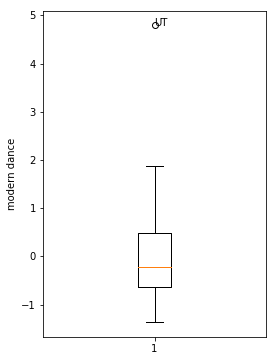

In [26]:
fig = pylab.figure(figsize=(4,6))
ax = fig.add_subplot(1, 1, 1)
for name, y in zip(un_outliers_name, un_outliers_data):
    ax.text(1, y, name)
ax.boxplot(data[param])
ax.set_ylabel(param)

##  Bivariate Outliers
Create a scatterplot with an ellipse as a boundary for outliers.

Use the Google search terms "data science" and "ceo" for this example.

In [8]:
params = ["data science", "ceo"]
params_data = np.array([df[params[0]], df[params[1]]]).T

Compute the "elliptical envelope." EE fits the tightest Gaussian (smallest volume ellipsoid) that it can while discarding some fixed fraction of contamination points.  Contamination - The amount of contamination of the data set, i.e. the proportion of outliers in the data set

In [9]:
ee = EllipticEnvelope()
ee.fit(params_data)

EllipticEnvelope(assume_centered=False, contamination=0.1, random_state=None,
         store_precision=True, support_fraction=None)

Get the names and positions of outliers.

In [10]:
biv_outliers_mask = ee.predict(params_data) == -1
biv_outliers_data = params_data[biv_outliers_mask]
biv_outliers_name = state_code[biv_outliers_mask]

Calculate the decision boundary for the scatterplot.

In [11]:
xx, yy = np.meshgrid(np.linspace(params_data[:, 0].min(), params_data[:, 0].max(), 100),
                     np.linspace(params_data[:, 1].min(), params_data[:, 1].max(), 100))
zz = ee.decision_function(np.c_[xx.ravel(), yy.ravel()])
zz = zz.reshape(xx.shape)

Draw the scatterplot with the elliptical envelope and label the outliers.

Text(0,0.5,'ceo')

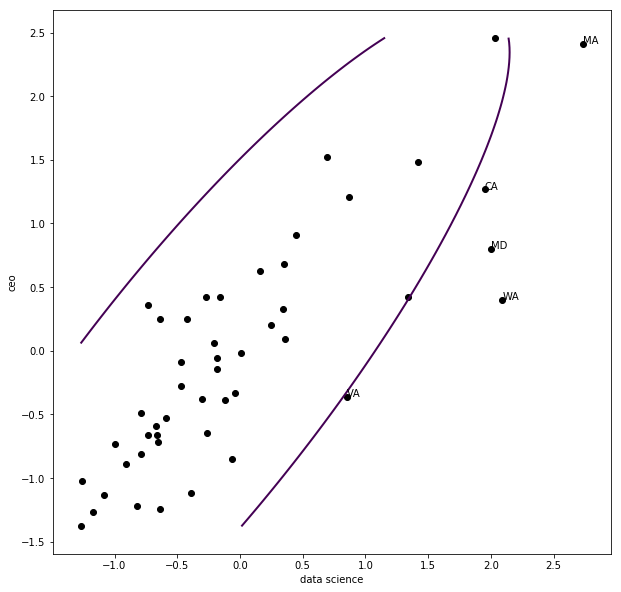

In [12]:
fig = pylab.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
for name, xy in zip(biv_outliers_name, biv_outliers_data):
    ax.text(xy[0], xy[1], name)
ax.contour(xx, yy, zz, levels=[0], linewidths=2)
ax.scatter(params_data[:, 0], params_data[:, 1], color='black')
ax.set_xlabel(params[0])
ax.set_ylabel(params[1])

##  Multivariate Outliers
Use the one-class support vector machine (SVM) algorithm to classify unusual cases.  Note that this is known to be sensitive to outliers.

In [13]:
ocsvm = OneClassSVM(nu=0.25, gamma=0.05)
ocsvm.fit(data)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.05, kernel='rbf',
      max_iter=-1, nu=0.25, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

List the names of the outlying states based on the one-class SVM.

In [14]:
# 
state_code[ocsvm.predict(data) == -1]

7     FL
13    KS
14    KY
16    ME
17    MD
18    MA
19    MI
20    MN
21    MS
24    NE
25    NV
27    NJ
28    NM
30    NC
33    OK
39    TN
43    VA
Name: state_code, dtype: object